## 시퀀스 배열로 다루는 순환 신경망 (RNN)
- 문장은 여러개의 단어로 이루어져 있는데, 그 의미를 전달하려면 각 단어가 정해진 순서대로 입력되어야 한다.
- 여러 데이터가 순서와 관계없이 입력되던 것과 다르게, 이번에는 과거에 입력된 데이터와 나중에 입력된 데이터 사이의 관계를 고려해야하는 문제가 생긴다.
### 순환 신경망 (Recurrent Neural Network, RNN)
- RNN은 여러개의 데이터가 순서대로 입력되었을때 앞서 입력받은 데이터를 잠시 기억해 놓는다.
- 기억된 데이터가 얼마나 중요한지 판단하고 별도의 가중치를 주어 다음 데이터로 넘어간다.

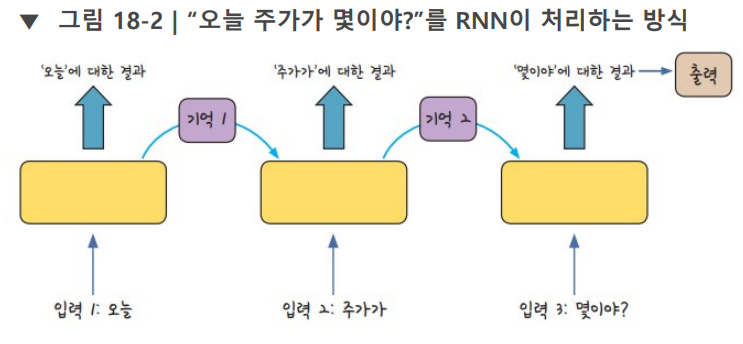

- 순환되는 중에 앞서 나온 입력에 대한 결과가 뒤에 나오는 입력 값에 영향을 주는 것을 볼 수 있다.
- ==> 이렇게 하여 비슷한 두 문장이 입력되었을 때, 그 차이를 구별해 출력값에 반영할 수 있다.

### LSTM (Long Short Term Memory)
: RNN의 결과를 더욱 개선하기 위해 사용하는 기법 중 가장 널리 사용되고 있다.
- 한 층 안에서 반복을 많이 하는 RNN의 특성상 일반 신경망보다 기울기 소실 문제가 더 많이 발생하고 이를 해결하기 어렵다는 단점을 보완한다.
- 반복되지 직전에 다음 층으로 기억된 값을 넘길지 여부를 관리하는 단계를 하나 더 추가한다.

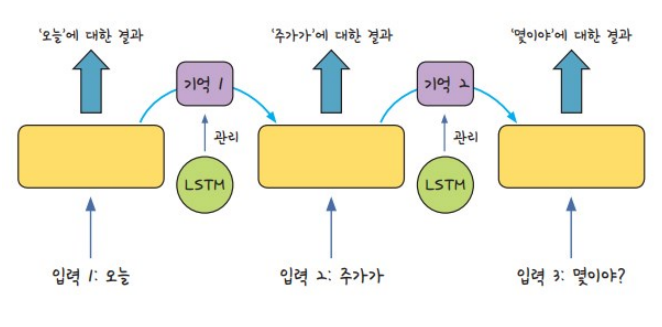

### RNN의 활용
1. 다수 입력 단일 출력
: 문장을 읽고 뜻을 파악할 때 활용

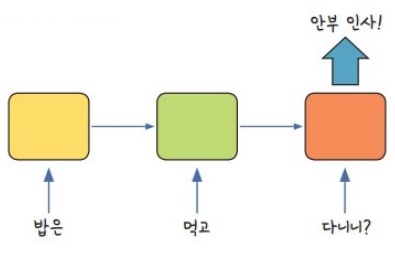

2. 단일 입력 다수 출력
: 사진의 캡션을 만들 때 활용

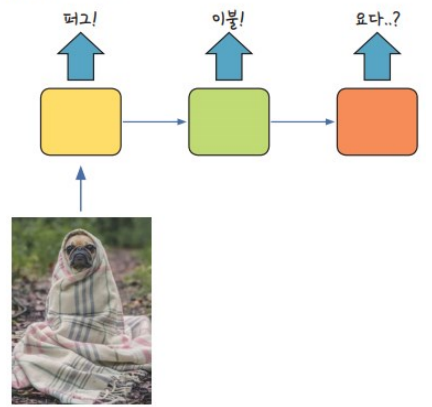

3. 다수 입력 다수 출력
: 문장의 번역

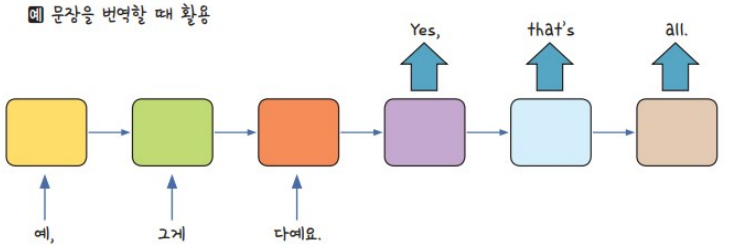

### 1. LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
# 모든 단어를 다 사용하는 것은 비효율적이므로 빈도가 높은 단어만 불러와 사용
# ==> 테스트셋과 학습셋으로 나눌 때 num_words = 1000을 적용함으로 반도가 1~1,000에 해당하는 단어만 선택해서 불러온다
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 데이터를 확인해 보겠습니다.
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


==> 단어를 수치화하는 전처리가 끝난 자료임을 알 수 있다

##### 1. 훈련용 뉴스 데이터의 기사 길이 확인

뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


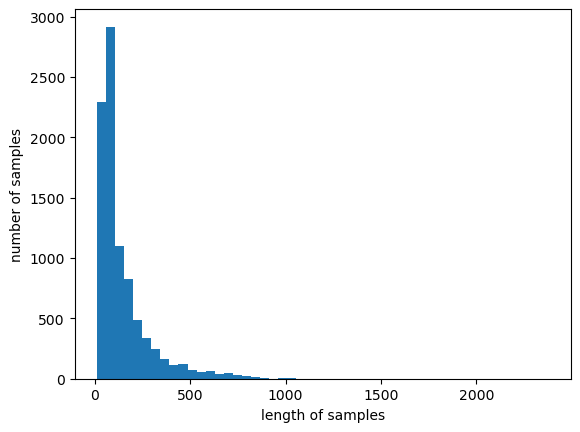

In [8]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### 2. 각 뉴스 레이블 값의 분포를 확인하고 각 레이블에 대한 정확한 개수를 출력

In [9]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


##### 3. 정수 인코딩된 각 숫자들이 어떤 단어들을 나타내고 있는지 확인

In [12]:
word_to_index = reuters.get_word_index()
print(word_to_index)

550378/550378 [==============================] - 0s 0us/step
{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, 'sation': 20673, 'chanthaburi': 20675, 'refunding': 10997, 'hermann': 8804, 'passsengers': 20676, 'stipulate': 20677, 'heublein': 8352, 'screaming': 20713, 'tcby': 16261, 'four': 185, 'grains': 1642, 'broiler': 20680, 'wooden': 12090, 'wednesday': 1220, 'highveld': 13797, 'duffour': 7593, '0053': 20681, 'elections': 3914, '270': 2563, '271': 3551, '272': 5113, '273': 3552, '274': 3400, 'rudman': 7975, '276': 3401, '277': 3478, '278': 3632, '279': 4309, 'dormancy': 9381, 'errors': 7247, 'deferred': 3086, 'sptnd': 20683, 'cooking': 8805, 'stratabit': 20684, 'designing': 16262, 'metalurgicos': 20685, 'databank': 13798, '300er': 20686, 'shocks': 20687, 'nawg': 7972, 'tnta': 20688, 'perforations': 20689, 'affiliates': 2891, '27p': 20690, 'ching': 16263, 'china': 595, 'wagyu': 16264, 'affiliated': 3189, 'chino': 16265, 'chinh': 162

##### 4. 단어의 빈도수

In [13]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key
# 숫자 0 : 패딩, 숫자 1: 문장 시작의 시작 sos, 숫자 2: OOV (Out of Vocabulary) unk...
# 언어 모델 마다 기호는 다르지만 첫 세 숫자 이후, 즉 4번째가 실제 첫번째 단어가 된다
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[4]))
print('빈도수 상위 100등 단어 : {}'.format(index_to_word[103]))

빈도수 상위 1번 단어 : the
빈도수 상위 100등 단어 : group


In [14]:
# 첫번째 기사
for index, token in enumerate(("", "", "")):
  index_to_word[index] = token
print(' '.join([index_to_word[index] for index in X_train[0]]))

                said as a result of its december acquisition of  co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and   revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash  per share this year should be 2 50 to three dlrs reuter 3


In [10]:
# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리를 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))     # LSTM은 tanh을 활성화 함수를 쓴다.
model.add(Dense(46, activation='softmax'))

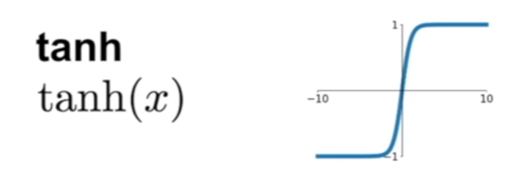

In [11]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
450/450 [==============================] - 39s 80ms/step - loss: 2.2038 - accuracy: 0.4469 - val_loss: 1.8777 - val_accuracy: 0.5209
Epoch 2/200
450/450 [==============================] - 34s 75ms/step - loss: 1.9058 - accuracy: 0.5156 - val_loss: 1.7476 - val_accuracy: 0.5410
Epoch 3/200
450/450 [==============================] - 33s 74ms/step - loss: 1.6861 - accuracy: 0.5655 - val_loss: 1.6710 - val_accuracy: 0.5833
Epoch 4/200
450/450 [==============================] - 29s 65ms/step - loss: 1.6512 - accuracy: 0.5826 - val_loss: 1.5858 - val_accuracy: 0.6086
Epoch 5/200
450/450 [==============================] - 31s 68ms/step - loss: 1.4357 - accuracy: 0.6391 - val_loss: 1.4250 - val_accuracy: 0.6451
Epoch 6/200
450/450 [==============================] - 30s 67ms/step - loss: 1.2862 - accuracy: 0.6791 - val_loss: 1.3460 - val_accuracy: 0.6558
Epoch 7/200
450/450 [==============================] - 30s 67ms/step - loss: 1.1916 - accuracy: 0.6962 - val_loss: 1.2768 - val_ac

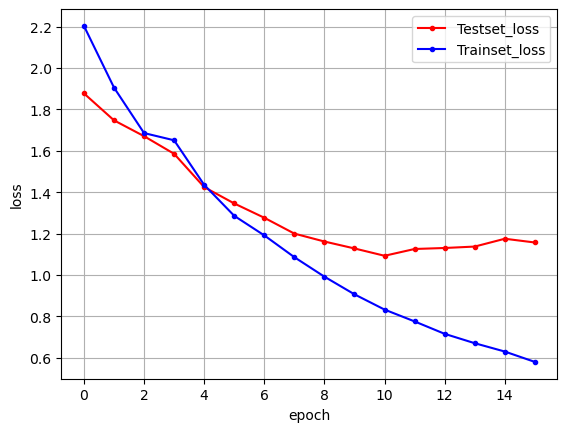

In [15]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기
- 로이터 뉴스 데이터와 마찬가지로 각 단어에 대한 전처리를 마친 상태
- 클래스가 긍정/부정 두가지뿐이라 원-핫 인코딩 과정이 필요 없다

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

17464789/17464789 [==============================] - 378s 22us/step


In [17]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [18]:
print(X_train[0])
print(y_train[0])       # y: 0 또는 1 - 긍정/부정

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
1


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


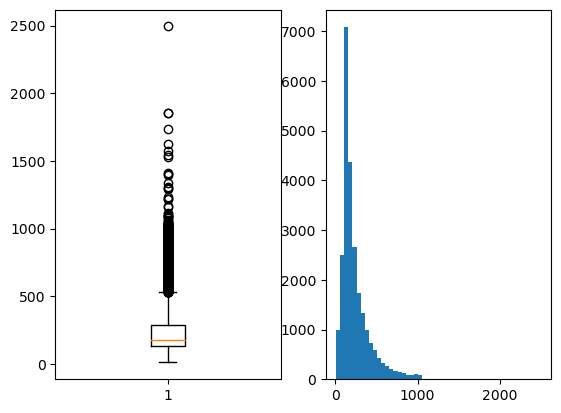

In [19]:
len_result = [len(s) for s in X_train]
print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [20]:
# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

In [21]:
# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         500000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 64)          0         
 D)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 55)                26400     
                                                                 
 dense_2 (Dense)             (None, 1)                 56        
                                                      

##### Conv1D
- 2차원 배열을 가진 이미지와 달리 지금 다루고 있는 데이터는 배열 형태로 이루어진 1차원
- Conv1D는 Conv2D의 개념을 1차원으로 옮긴것 : 컨볼루션 층이 1차원이고 이동하는 배열도 1차원

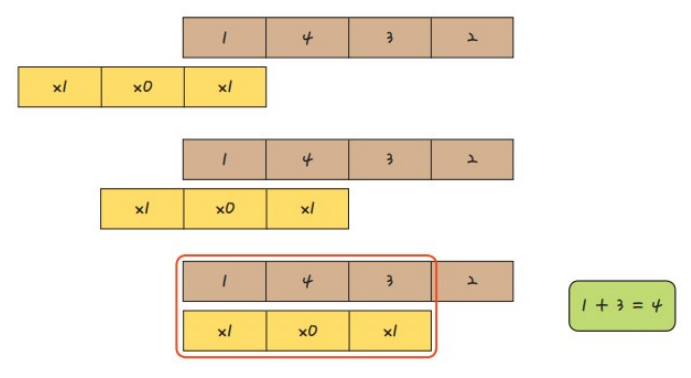
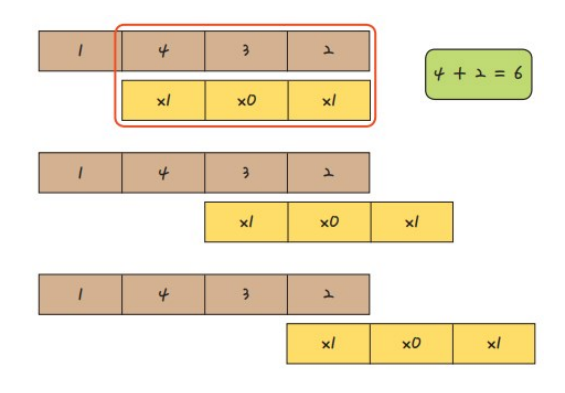

- 노란색 배열 : 커널 ==> 이 커널이 지나가면서 원래의 1차원 배열에 가중치를 각각 곱해 새로운 층인 컨볼루션 층을 만듦

##### MaxPooling1D
- MaxPooling1D도 마찬가지
- 2차원 배열을 1차원으로 바꾸어 정해진 구역 안에서 가장 큰 값을 다음 층으로 넘기고 나머지는 버림.

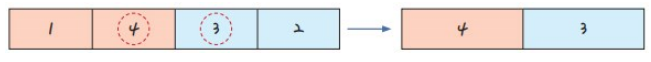

In [22]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
469/469 [==============================] - 102s 210ms/step - loss: 0.4066 - accuracy: 0.8028 - val_loss: 0.2799 - val_accuracy: 0.8840
Epoch 2/100
469/469 [==============================] - 98s 209ms/step - loss: 0.2320 - accuracy: 0.9103 - val_loss: 0.2584 - val_accuracy: 0.8920
Epoch 3/100
469/469 [==============================] - 95s 202ms/step - loss: 0.1827 - accuracy: 0.9310 - val_loss: 0.2819 - val_accuracy: 0.8850
Epoch 4/100
469/469 [==============================] - 93s 198ms/step - loss: 0.1430 - accuracy: 0.9481 - val_loss: 0.3261 - val_accuracy: 0.8818
Epoch 5/100
782/782 [==============================] - 31s 39ms/step - loss: 0.3475 - accuracy: 0.8748

 Test Accuracy: 0.8748


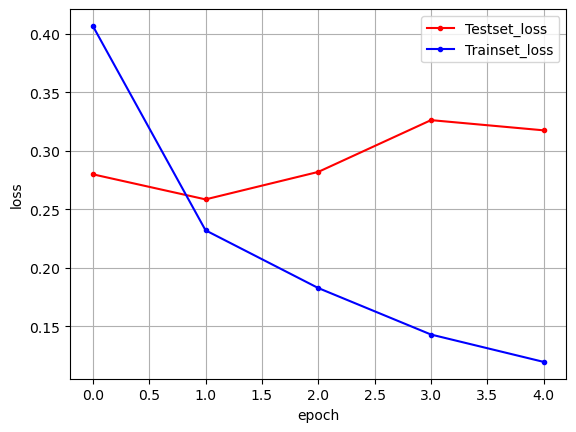

In [25]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 3. 어텐션을 사용한 신경망
- 단백질 : 생명 활동의 기본 단위. 어떤 구조와 방식으로 움직이는지 이해하는 것은 생명 현상을 연구하는데 필수적
- 2020년 12월, 제 14회 세계단백질 구조 예측 대회에서 특출나게 단백징 구조를 예측한 알파폴드 2가 등장!
- 구글의 딥마인드가 단백질 구조 예측을 위해 만듦
- 알파폴드의 중요한 축을 담당하고 있는 것이 바로 **어텐션 (Attention)** 알고리즘

##### RNN의 한계

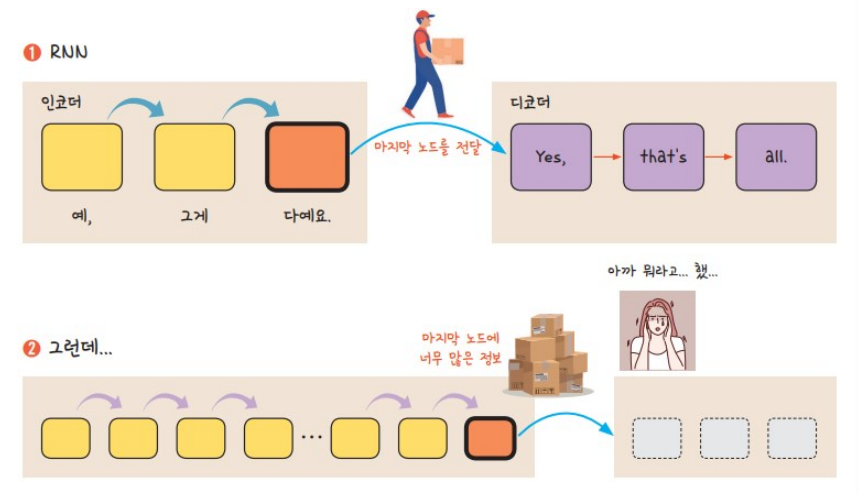

- RNN : 여러 개의 입력값이 있을 때 이를 바로 처리하는 것이 아니라 잠시 가지고 있는다. 입력값끼리 서로 관련이 있다면 이를 모두 받아 두어야 적절한 출력값을 만들 수 있다.
- (1) 인코더에 입력된 각 셀 값을 하나씩 뒤로 보내다가, 마지막 셍리 이 값을 디코더에 전달 ==> 이 마지막 셀에 담긴 값에 전체 문장의 뜻이 함축되어 있으므로 이를 **문맥 벡터 (context vector)** 라고 한다.
- (2)와 같이 입력값의 실이가 너무 길면 입력받은 셀의 결과들이 너무 많아진다
- ==> 입력이 길면 선두에서 전달받은 결과값이 중간에 희미해지기도 하고, 문맥 벡터가 모든 값을 제대로 디코더에 전달하기 힘들어지는 문제가 발생!
- 이를 처리하기 위한 방법 : 어텐션

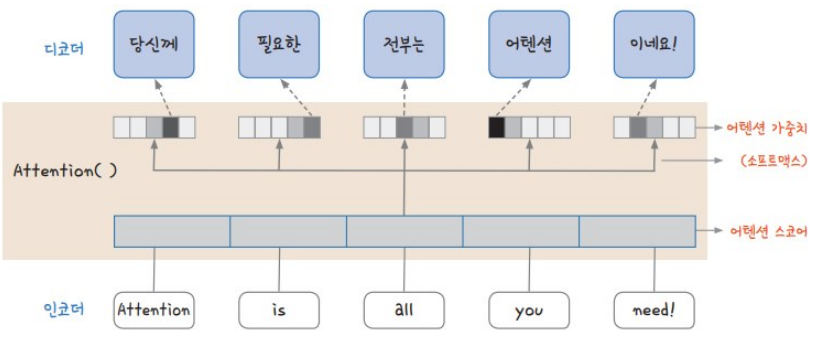

- 인코더와 디코더 사이에 층이 하나 생겨서 이 층에 각 셀로부터 계산된 스코어들이 모인다.
- 이 스코어와 소프트맥스 함수를 사용해서 어텐션 가중치를 만듦.
- 이 가중치를 이용해 입력값 중 어떤 셀을 중심적으로 볼지 결정.
- 예 : 첫번째 출력 단어인 '당신께'자리에 가장 적절한 단어는 4번째 셀 'you'라는 것을 학습.
- 이러한 방식으로 매 출력마다 모든 입력값을 두루 활용하게 하는 것이 **어텐션**
- 마지막 셀에 모든 입력이 집중되던 RNN의 단점을 극복해낸 알고리즘.
- 그림의 회색 사각형 부분을 Attention( )함수가 처리.
```
    model.add(Attention())
```

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from attention import Attention

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

In [26]:
# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [27]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100,  validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
625/625 [==============================] - 884s 1s/step - loss: 0.3684 - accuracy: 0.8356 - val_loss: 0.2798 - val_accuracy: 0.8815
Epoch 2/100
625/625 [==============================] - 771s 1s/step - loss: 0.2225 - accuracy: 0.9130 - val_loss: 0.2764 - val_accuracy: 0.8912
Epoch 3/100
625/625 [==============================] - 781s 1s/step - loss: 0.1657 - accuracy: 0.9360 - val_loss: 0.3197 - val_accuracy: 0.8869
Epoch 4/100
625/625 [==============================] - 743s 1s/step - loss: 0.1183 - accuracy: 0.9540 - val_loss: 0.3353 - val_accuracy: 0.8875
Epoch 5/100
782/782 [==============================] - 136s 173ms/step - loss: 0.4249 - accuracy: 0.8743

 Test Accuracy: 0.8743


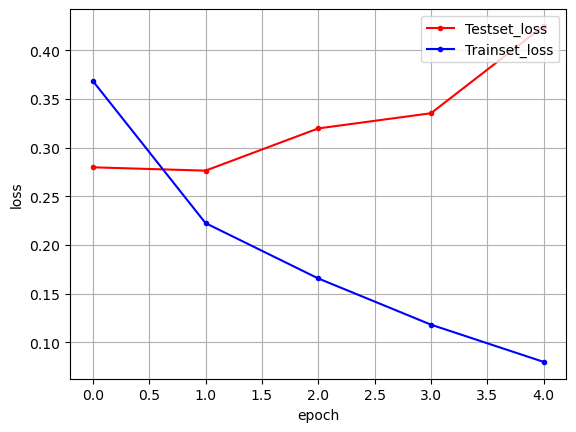

In [28]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()